# Modeling heterogeneous multiband data with correlated fields

__Author__ : Aymeric Galan

__Updated__ : 12/02/25

In [1]:
import os
import multiprocessing

# this is truly relevant only when using jax.pmap... which does not work here
os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count={}".format(
    multiprocessing.cpu_count()
)

In [2]:
%matplotlib inline
# %config InlineBackend.figure_format = 'retina'  # for better looking figures

__author__ = 'aymgal'

import numpy as np
from scipy import ndimage
import matplotlib.pyplot as plt
plt.rc('image', interpolation='none', origin='lower')
from matplotlib.colors import AsinhNorm, LogNorm, TwoSlopeNorm
from copy import deepcopy
from pprint import pprint

from jax import config
config.update("jax_enable_x64", True)  # could actually make a difference with correlated jifty
import jax
import jax.numpy as jnp

# probabilistic model and inference
import numpyro
import numpyro.distributions as dist
from numpyro.distributions import constraints

# Len modelling
import herculens as hcl
from herculens.Util import plot_util, param_util

# Creating masks
from imd.image_mask import ImageMask

In [3]:
num_devices = jax.local_device_count()
print("Number of JAX devices:", num_devices)

Number of JAX devices: 12


In [4]:
TEST_MODE = False  # will shorten everything if True

SECOND_BAND_TYPE = 'multi_band'  # 'multi_band' or 'multi_exp'

SEED_DATA = 0  # another see will change the noise realisation in the data
SEED_INIT = 86741  # another seed will change the set if the initial model parameters

NUM_START = 8    # number of optimisation runs from different initial positions

NUM_PIX_SRC = 100
BORDER_FIELD_XY = 10
BORDER_FIELD_WL = 2

object_name = 'mock_mb'

## Simulate the multi-band or multi-exposure data set

In [5]:
# some numerics settings for simulation and modelling
kwargs_numerics = {
    'supersampling_factor': 3,
    'convolution_type': 'jax_scipy_fft',
    'supersampling_convolution': False,
}

In [6]:
def simulate_single_band(
        prng_key_noise,
        cutout_size_arcsec=6.4, pix_scl=0.08, bkg_rms=1e-4, exp_time=1000., fwhm_psf=0.3,
        amp_lens=1., amp_source_1=1., amp_source_2=1.,
    ):
    # Coordinates grid
    npix = int(cutout_size_arcsec / pix_scl)  # number of pixel on a side
    half_size = npix * pix_scl / 2
    ra_at_xy_0 = dec_at_xy_0 = -half_size + pix_scl / 2  # position of the (0, 0) with respect to bottom left pixel
    transform_pix2angle = pix_scl * np.eye(2)  # transformation matrix pixel <-> angle
    kwargs_pixel = {'nx': npix, 'ny': npix,
                    'ra_at_xy_0': ra_at_xy_0, 'dec_at_xy_0': dec_at_xy_0,
                    'transform_pix2angle': transform_pix2angle}

    # create the PixelGrid class
    pixel_grid = hcl.PixelGrid(**kwargs_pixel)
    xgrid, ygrid = pixel_grid.pixel_coordinates
    extent = pixel_grid.extent

    print(f"image size : ({npix}, {npix}) pixels")
    print(f"pixel size : {pix_scl} arcsec")
    print(f"x range    : {xgrid[0, 0], xgrid[0, -1]} arcsec")
    print(f"y range    : {ygrid[0, 0], ygrid[-1, 0]} arcsec")

    # PSF
    psf = hcl.PSF(psf_type='GAUSSIAN', fwhm=fwhm_psf, pixel_size=pix_scl)

    # Noise
    noise = hcl.Noise(npix, npix, background_rms=bkg_rms, exposure_time=exp_time)

    # Lens mass
    lens_mass_model_input = hcl.MassModel([hcl.SIE(), hcl.Shear()])

    # position of the lens
    cx0, cy0 = 0., 0.
    # position angle, here in degree
    phi = 8.0
    # axis ratio, b/a
    q = 0.75
    # conversion to ellipticities
    e1, e2 = param_util.phi_q2_ellipticity(phi * np.pi / 180, q)
    # external shear orientation, here in degree
    phi_ext = 54.0
    # external shear strength
    gamma_ext = 0.03 
    # conversion to polar coordinates
    gamma1, gamma2 = param_util.shear_polar2cartesian(phi_ext * np.pi / 180, gamma_ext)
    print(e1, e2)
    print(gamma1, gamma2)
    kwargs_lens_input = [
        {'theta_E': 1.5, 'e1': e1, 'e2': e2, 'center_x': cx0, 'center_y': cy0},  # SIE
        {'gamma1': gamma1, 'gamma2': gamma2, 'ra_0': 0.0, 'dec_0': 0.0}  # external shear
    ]
    #pprint(kwargs_lens_input)

    # Lens light
    lens_light_model_input = hcl.LightModel(hcl.SersicElliptic())
    kwargs_lens_light_input = [
        {'amp': amp_lens, 'R_sersic': 1.0, 'n_sersic': 3., 'e1': e1, 'e2': e2, 'center_x': cx0, 'center_y': cy0}
    ]
    #pprint(kwargs_lens_light_input)

    # Source light
    source_model_input = hcl.LightModel([hcl.SersicElliptic(), hcl.GaussianLight()])
    src_pos_x, src_pos_y = 0.04, 0.12
    kwargs_source_input = [
        {'amp': amp_source_1, 'R_sersic': 0.2, 'n_sersic': 2., 'e1': 0.05, 'e2': 0.05, 'center_x': src_pos_x, 'center_y': src_pos_y},
        {'amp': amp_source_2, 'sigma': 0.05, 'center_x': 0.3, 'center_y': 0.3} # add a bit of complexity in the source galaxy
    ]

    # Generate a lensed image based on source and lens models
    lens_image_simu = hcl.LensImage(pixel_grid, psf, noise_class=noise,
                            lens_mass_model_class=lens_mass_model_input,
                            source_model_class=source_model_input,
                            lens_light_model_class=lens_light_model_input,
                            kwargs_numerics=kwargs_numerics)

    kwargs_all_input = dict(kwargs_lens=kwargs_lens_input,
                            kwargs_source=kwargs_source_input,
                            kwargs_lens_light=kwargs_lens_light_input)

    # clean image (no noise)
    # image = lens_image_simu.model(**kwargs_all_input)

    # simulated observation including noise
    data_sgl = lens_image_simu.simulation(**kwargs_all_input, compute_true_noise_map=True, prng_key=prng_key_noise)
    data_sgl = np.array(data_sgl)

    return data_sgl, lens_image_simu, kwargs_all_input

In [7]:
prng_key_b1, prng_key_b2 = jax.random.split(jax.random.PRNGKey(SEED_DATA))

# BAND 1, something like Euclid/VIS
props_band1 = dict(
    pix_scl=0.1, bkg_rms=1e-4, exp_time=1000., fwhm_psf=0.16,
    amp_lens=8., amp_source_1=1., amp_source_2=0.3,
)
data_b1, lens_image_input_b1, kwargs_input_b1 = simulate_single_band(
    prng_key_b1, **props_band1,
)

# BAND 2
if SECOND_BAND_TYPE == 'multi_exp':
    # this will be just other realisations of the same data
    data_b2, lens_image_input_b2, kwargs_input_b2 = simulate_single_band(
        prng_key_b2, **props_band1,
    )
elif SECOND_BAND_TYPE == 'multi_band':  # something like HST/UVIS
    # this will be the same system but with another instrument and band
    props_band2 = dict(
        pix_scl=0.04, bkg_rms=1e-4, exp_time=1000., fwhm_psf=0.1,
        amp_lens=3., amp_source_1=8., amp_source_2=0.8,
    )
    data_b2, lens_image_input_b2, kwargs_input_b2 = simulate_single_band(
        prng_key_b2, **props_band2,
    )
else:
    raise NotImplementedError()

image size : (64, 64) pixels
pixel size : 0.1 arcsec
x range    : (-3.1500000000000004, 3.1500000000000004) arcsec
y range    : (-3.1500000000000004, 3.1500000000000004) arcsec
0.13732309941975984 0.03937676511671417
-0.00927050983124842 0.02853169548885461
image size : (160, 160) pixels
pixel size : 0.04 arcsec
x range    : (-3.18, 3.18) arcsec
y range    : (-3.18, 3.18) arcsec
0.13732309941975984 0.03937676511671417
-0.00927050983124842 0.02853169548885461


In [8]:
def create_plotter(data, lens_image, kwargs_params, flux_vmin=8e-3, flux_vmax=6e-1):
    # Plotting engine
    plotter = hcl.Plotter(flux_vmin=flux_vmin, flux_vmax=flux_vmax,
                          ref_lens_image=lens_image, ref_kwargs_result=kwargs_params)

    # inform the plotter of the data and, if any, the true source
    plotter.set_data(data)
    return plotter

plotter_b1 = create_plotter(data_b1, lens_image_input_b1, kwargs_input_b1, 
                            flux_vmin=1e-3, flux_vmax=1e0)
plotter_b2 = create_plotter(data_b2, lens_image_input_b2, kwargs_input_b2, 
                            flux_vmin=1e-3, flux_vmax=1e0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.15843737832548566..3.333333333333333].


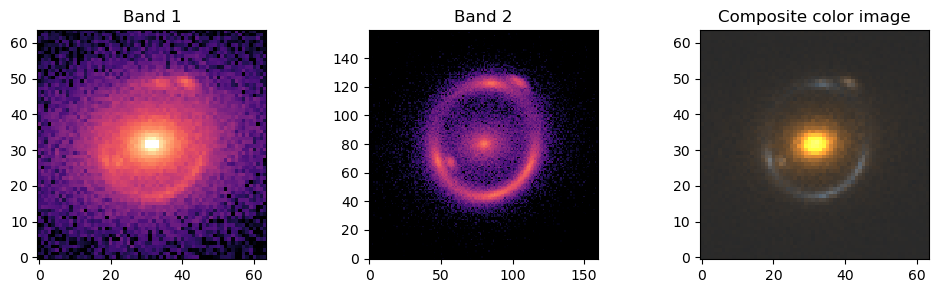

In [9]:
def plot_two_bands(band1, band2, norm_b1=plotter_b1.norm_flux, norm_b2=plotter_b2.norm_flux):
    if band2.shape[0] > band1.shape[0]:
        # create a downscaled version of the high resolution band that matches the low resolution band
        band2_reshaped = ndimage.zoom(band2, band1.shape[0]/band2.shape[0], order=3)
    else:
        band2_reshaped = band2

    # create a fake RGB color image from the two bands
    data_rgb = np.zeros((band1.shape[0], band1.shape[1], 3))
    data_rgb[..., 0] = band1  # red
    data_rgb[..., 1] = 0.5 * (band1 + band2_reshaped)  # green
    data_rgb[..., 2] = band2_reshaped  # blue
    data_rgb = np.arcsinh(data_rgb)
    data_rgb -= data_rgb.min() - np.abs(data_rgb.max())*0.05
    data_rgb /= data_rgb.max() * 0.3

    # plot the data as separate bands and as a color image
    fig, ax = plt.subplots(1, 3, figsize=(10, 3))
    ax[0].imshow(band1, origin='lower', cmap=plotter_b1.cmap_flux, norm=norm_b1)
    ax[0].set_title('Band 1')
    ax[1].imshow(band2, origin='lower', cmap=plotter_b2.cmap_flux, norm=norm_b2)
    ax[1].set_title('Band 2')
    ax[2].imshow(data_rgb, origin='lower')
    ax[2].set_title('Composite color image')
    fig.tight_layout()
    plt.show()

plot_two_bands(data_b1, data_b2)

## Define the model components

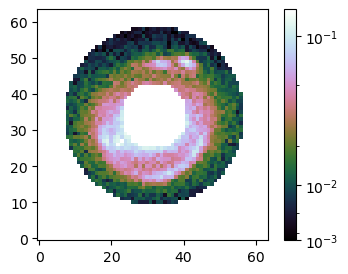

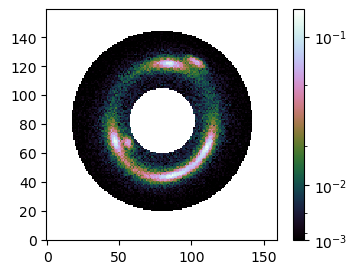

In [10]:
def create_arc_mask(data, lens_image, thickness=1., show_details=False):
    npix = lens_image.Grid.num_pixel_axes[0]
    pix_scl = lens_image.Grid.pixel_width
    # pix_scl_base = 0.08
    # defines a suitable arc mask
    arc_mask_inner_radius = 0.9
    arc_mask_outer_radius = arc_mask_inner_radius + thickness
    # mask_center = (42*pix_scl_base, 40*pix_scl_base)
    mask_center = (npix/2.*pix_scl+2*pix_scl, npix/2.*pix_scl)
    mask_kwargs = {
        'mask_type_list': ['ellipse', 'circle'],
        'radius_list': [arc_mask_outer_radius] + [arc_mask_inner_radius], 
        'axis_ratio_list': [1] + [1],
        'angle_list': [0] + [0],
        'center_list': [mask_center] + [mask_center],
        'inverted_list': [False] + [True], 
        'operation_list': ['inter'],
    }

    image_mask_arc = ImageMask(
        mask_shape=(npix, npix),
        delta_pix=pix_scl,
        **mask_kwargs
    )
    arc_mask = image_mask_arc.get_mask(show_details=show_details)

    data_masked = data.copy()
    data_masked[arc_mask == 0] = np.nan

    plt.figure(figsize=(4, 3))
    plt.imshow(data_masked, origin='lower',  cmap='cubehelix', norm=AsinhNorm(0.01, 1e-3))
    plt.colorbar()
    plt.show()

    return arc_mask

arc_mask_b1 = create_arc_mask(data_b1, lens_image_input_b1, thickness=1.6)
arc_mask_b2 = create_arc_mask(data_b2, lens_image_input_b2, thickness=1.6)

In [11]:
def create_model_single_band(lens_image_simu, source_arc_mask):
    # Same PSF
    psf_model = lens_image_simu.PSF
    # Same noise model
    noise_model = hcl.Noise(
        lens_image_simu.Grid.num_pixel_axes[0], 
        lens_image_simu.Grid.num_pixel_axes[1],
        background_rms=lens_image_simu.Noise.background_rms, 
        exposure_time=lens_image_simu.Noise.exposure_map,
    )
    # Same lens mass model
    lens_mass_model = hcl.MassModel(lens_image_simu.MassModel.profile_type_list)
    # In this case the source plane extent will adapt to the arc mask
    # and only the fixed number of source pixels is required.
    num_source_pixels = NUM_PIX_SRC if not TEST_MODE else 10
    kwargs_source_plane = {
        'num_pixels': num_source_pixels,
    }
    source_light_model = hcl.LightModel(
        hcl.PixelatedLight(
            interpolation_type='fast_bilinear', 
            adaptive_grid=True,  # source grid extent will adapt using the arc mask
            allow_extrapolation=False,  # essentially says it should be zero outside the source grid
        ),
        kwargs_pixelated=kwargs_source_plane,
    )

    lens_image = hcl.LensImage(
        lens_image_simu.Grid, 
        psf_model,
        noise_class=noise_model, 
        lens_mass_model_class=lens_mass_model,
        lens_light_model_class=deepcopy(lens_image_simu.LensLightModel),
        source_model_class=source_light_model, 
        source_arc_mask=source_arc_mask.astype(bool),
        kwargs_numerics=kwargs_numerics,
    )
    return lens_image

In [12]:
# The model engines for each band
lens_image_b1 = create_model_single_band(lens_image_input_b1, arc_mask_b1)
lens_image_b2 = create_model_single_band(lens_image_input_b2, arc_mask_b2)

# Wrapping this into a 3D model
lens_image_mb = hcl.LensImage3D(
    [lens_image_b1, lens_image_b2],
    mode='list',  # important when bands have different cutout size, number of pixels, etc.
    reference_lens_image=0, 
    join_source_coords=True,  # makes sure the 3D correlated field defined below has joint coordinates over the bands
)

In [13]:
# The spatial-spectral source field model that will be used for both bands
ref_source_light_model = lens_image_b1.SourceModel
mean_source_intensity = 1e-4
source_field_mb = hcl.CorrelatedField(
    "source_pixels",   # the key that will be used to in all underlying field parameters names
    ref_source_light_model,   # will be used to gather information about the pixelated grid

    offset_mean=np.log(mean_source_intensity),  # take the log because exponentiate=True
    prior_offset_std=(0.5, 1e-6),

    correlation_type='amplitude',
    prior_loglogavgslope=(-3., 1), 
    prior_fluctuations=(1.5, 0.8),
    prior_flexibility=None,
    prior_asperity=None,

    num_pix_wl=2,  # number of bands
    correlation_type_wl='amplitude',
    prior_loglogavgslope_wl=(-2., 0.5), 
    prior_fluctuations_wl=(0.2, 0.5),
    cropped_border_size=BORDER_FIELD_XY,
    cropped_border_size_wl=BORDER_FIELD_WL,
    
    exponentiate=True,
)

Exponential Cropped correlated field prior for 'source_pixels'
New '3d' CorrelatedField model successfully created (final shape is (2, 100, 100).


#### Visualize the unoptimized correlated field (drawn from the prior)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.16443789968649822..3.3333333333333335].


(2, 100, 100)


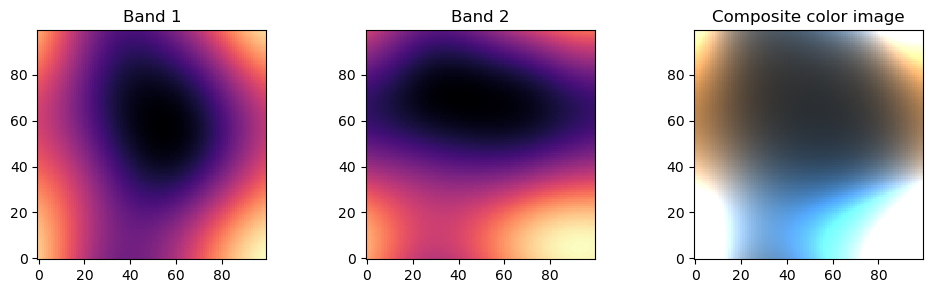

In [14]:
field_real = source_field_mb.draw_realizations_from_prior(jax.random.PRNGKey(9), num_samples=1)
print(field_real.shape)

plot_two_bands(field_real[0], field_real[1], norm_b1=LogNorm(), norm_b2=LogNorm())

## Design the probabilistic model

In [15]:
class MyProbModel3D(hcl.NumpyroModel):

    def model(self):
        # Joint prior for the source, selecting the right slice for each band
        source_pixels_mb = source_field_mb.numpyro_sample_pixels()  # this is a cube with shape (num_bands, num_source_pixels, num_source_pixels)
        prior_source_list = [
            [{'pixels': source_pixels_mb[0]}],
            [{'pixels': source_pixels_mb[1]}],
        ]
        # Joint prior for the lens
        kwargs_ref = kwargs_input_b1
        cx = numpyro.sample('light_cx', dist.TruncatedNormal(kwargs_ref['kwargs_lens_light'][0]['center_x'], 0.04, low=-0.1, high=0.1))
        cy = numpyro.sample('light_cy', dist.TruncatedNormal(kwargs_ref['kwargs_lens_light'][0]['center_x'], 0.04, low=-0.1, high=0.1))
        e1 = numpyro.sample('light_e1', dist.TruncatedNormal(kwargs_ref['kwargs_lens'][0]['e1'], 0.05, low=-0.2, high=0.2))
        e2 = numpyro.sample('light_e2', dist.TruncatedNormal(kwargs_ref['kwargs_lens'][0]['e2'], 0.05, low=-0.2, high=0.2))
        # e1 = numpyro.sample('light_e1', dist.Normal(kwargs_ref['kwargs_lens'][0]['e1'], 0.05))
        # e2 = numpyro.sample('light_e2', dist.Normal(kwargs_ref['kwargs_lens'][0]['e2'], 0.05))
        prior_lens = [
            # power-law
            {
                'theta_E': numpyro.sample(
                    'lens_theta_E', dist.Uniform(kwargs_ref['kwargs_lens'][0]['theta_E']-0.02, kwargs_ref['kwargs_lens'][0]['theta_E']+0.02)
                ),
                'e1': e1,
                'e2': e2,
                'center_x': cx, 
                'center_y': cy,
            },
            # external shear, with fixed origin
            {
                'gamma1': numpyro.sample('lens_gamma1', dist.TruncatedNormal(kwargs_ref['kwargs_lens'][1]['gamma1'], 0.05, low=-0.2, high=0.2)), 
                'gamma2': numpyro.sample('lens_gamma2', dist.TruncatedNormal(kwargs_ref['kwargs_lens'][1]['gamma2'], 0.05, low=-0.2, high=0.2)), 
                # 'gamma1': numpyro.sample('lens_gamma1', dist.Normal(kwargs_input_b1['kwargs_lens'][1]['gamma1'], 0.08)), 
                # 'gamma2': numpyro.sample('lens_gamma2', dist.Normal(kwargs_input_b1['kwargs_lens'][1]['gamma2'], 0.08)), 
                'ra_0': 0.0, 
                'dec_0': 0.0,
            }
        ]
        # Fixed lens light
        prior_lens_light_list = [
            kwargs_input_b1['kwargs_lens_light'],
            kwargs_input_b2['kwargs_lens_light'],
        ]
        model_params = dict(kwargs_lens=prior_lens, 
                            kwargs_lens_light_list=prior_lens_light_list,
                            kwargs_source_list=prior_source_list)
        
        # generates the model image jointly, which ensures consistent source grid treatment
        model_image_b1, model_image_b2 = lens_image_mb.model(
            **model_params, 
        )
        
        # estimate the error per pixel for each band (for now separately)
        model_std_b1 = jnp.sqrt(lens_image_b1.Noise.C_D_model(model_image_b1))
        model_std_b2 = jnp.sqrt(lens_image_b2.Noise.C_D_model(model_image_b2))
        
        # Finally defines the observed node, conditioned on the data assuming a Gaussian distribution.
        # Here would be the right place to use a likelihood mask to exclude pixels from the likelihood, if needed.
        numpyro.sample(f'obs_b1', dist.Independent(dist.Normal(model_image_b1, model_std_b1), 2), obs=data_b1)
        numpyro.sample(f'obs_b2', dist.Independent(dist.Normal(model_image_b2, model_std_b2), 2), obs=data_b2)

    def params2kwargs(self, params):
        # Pack the parameters for Herculens
        # Source light for each band
        source_pixels_mb = source_field_mb.model(params)
        kwargs_source_list = [
            [{'pixels': source_pixels_mb[0]}],
            [{'pixels': source_pixels_mb[1]}]
        ]
        # Lens mass (for both bands)
        #e1_conv, e2_conv = param_util.phi_q2_ellipticity(params['lens_phi'], params['lens_q'])
        kwargs_lens = [
            {
                'theta_E': params['lens_theta_E'],
                'e1': params['light_e1'], 
                'e2': params['light_e2'],
                'center_x': params['light_cx'], 
                'center_y': params['light_cy'], 
            },
            {
                'gamma1': params['lens_gamma1'], 
                'gamma2': params['lens_gamma2'], 
            }
        ]
        
        # Lens light for each band (fixed to reference parameters here)
        kwargs_lens_light_list = [
            kwargs_input_b1['kwargs_lens_light'],
            kwargs_input_b2['kwargs_lens_light']
        ]

        # either we can return the kwargs as read by the LensImage3D class
        # return dict(kwargs_lens=kwargs_lens, 
        #             kwargs_lens_light_list=kwargs_lens_light_list, 
        #             kwargs_source_list=kwargs_source_list)

        # or we return the two bands separately for use with the LensImage class
        return (
            dict(kwargs_lens=kwargs_lens, 
                 kwargs_lens_light=kwargs_lens_light_list[0], 
                 kwargs_source=kwargs_source_list[0]
            ),
            dict(kwargs_lens=kwargs_lens, 
                 kwargs_lens_light=kwargs_lens_light_list[1], 
                 kwargs_source=kwargs_source_list[1]
            )
        )

prob_model = MyProbModel3D()
n_param = prob_model.num_parameters
print("Number of parameters:", n_param)

Number of parameters: 86412


In [16]:
# visualize the probabilistic graph thanks to NumPyro utility
#prob_model.render_model()

## Draw initial parameters from the prior

In [17]:
def visualize_initial_guess_sb(fig_axes, idx_row, plotter, data, initial_model):
    # visualize initial guess
    ax = fig_axes[idx_row, 0]
    ax.set_title("Initial guess model")
    im = ax.imshow(initial_model, origin='lower', norm=plotter.norm_flux, cmap=plotter.cmap_flux)
    plot_util.nice_colorbar(im)
    ax = fig_axes[idx_row, 1]
    ax.set_title("Data")
    im = ax.imshow(data, origin='lower', norm=plotter.norm_flux, cmap=plotter.cmap_flux)
    plot_util.nice_colorbar(im)
    ax = fig_axes[idx_row, 2]
    ax.set_title("Difference")
    im = ax.imshow(initial_model - data, origin='lower', norm=TwoSlopeNorm(0), cmap=plotter.cmap_res)
    plot_util.nice_colorbar(im)

def visualize_initial_guess_mb(init_params):
    # Evaluate the model
    init_kwargs_b1, init_kwargs_b2 = prob_model.params2kwargs(init_params)
    init_model_b1 = lens_image_b1.model(**init_kwargs_b1)
    init_model_b2 = lens_image_b2.model(**init_kwargs_b2)

    # visualize initial guess
    fig, axes = plt.subplots(2, 3, figsize=(7, 4))
    visualize_initial_guess_sb(axes, 0, plotter_b1, data_b1, init_model_b1)
    visualize_initial_guess_sb(axes, 1, plotter_b2, data_b2, init_model_b2)
    fig.tight_layout()
    plt.show()

In [18]:
# Draw a random initial guess from the prior
prng_key = jax.random.PRNGKey(SEED_INIT)
prng_key, prng_key_init = jax.random.split(prng_key)
# init_params = prob_model.get_sample(prng_key=prng_key_init)  # constrained space
# init_params_unconst = prob_model.unconstrain(init_params)  # UNconstrained space

# run num_start optimisations in parallel with independent seeds
num_start = NUM_START if not TEST_MODE else 2
prng_keys_optim = jax.random.split(prng_key_init, num_start)

In [19]:
# Define the loss
loss = hcl.Loss(prob_model)

INIT LENS PARAMS: {'light_cx': Array(-0.0261363, dtype=float64), 'light_cy': Array(0.08897496, dtype=float64), 'light_e1': Array(0.18416589, dtype=float64), 'light_e2': Array(-0.01331108, dtype=float64), 'lens_theta_E': Array(1.48303003, dtype=float64), 'lens_gamma1': Array(-0.00297003, dtype=float64), 'lens_gamma2': Array(0.0266523, dtype=float64)}


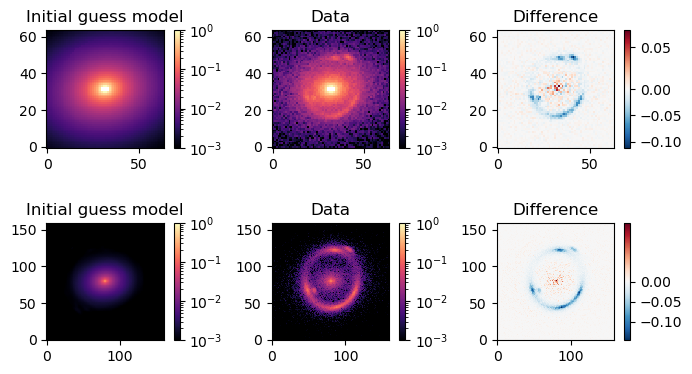

Initial loss for start 0 = 972654.2820058638
INIT LENS PARAMS: {'light_cx': Array(-0.03844433, dtype=float64), 'light_cy': Array(0.00418204, dtype=float64), 'light_e1': Array(0.09212566, dtype=float64), 'light_e2': Array(0.07397052, dtype=float64), 'lens_theta_E': Array(1.51588898, dtype=float64), 'lens_gamma1': Array(0.02679298, dtype=float64), 'lens_gamma2': Array(-0.08981691, dtype=float64)}


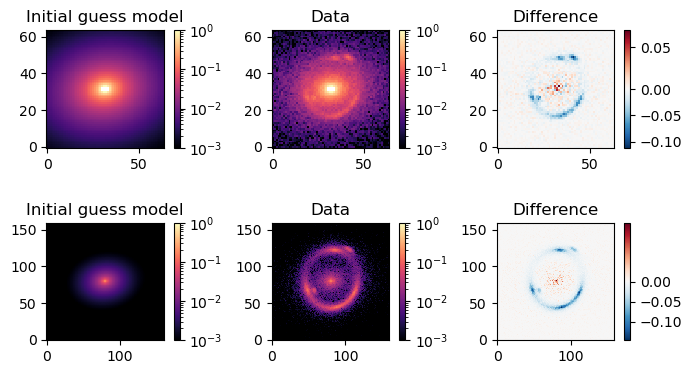

Initial loss for start 1 = 1086451.5928576412
INIT LENS PARAMS: {'light_cx': Array(-0.011765, dtype=float64), 'light_cy': Array(0.00404614, dtype=float64), 'light_e1': Array(0.10550584, dtype=float64), 'light_e2': Array(0.08889115, dtype=float64), 'lens_theta_E': Array(1.50189571, dtype=float64), 'lens_gamma1': Array(-2.76027687e-06, dtype=float64), 'lens_gamma2': Array(0.00866477, dtype=float64)}


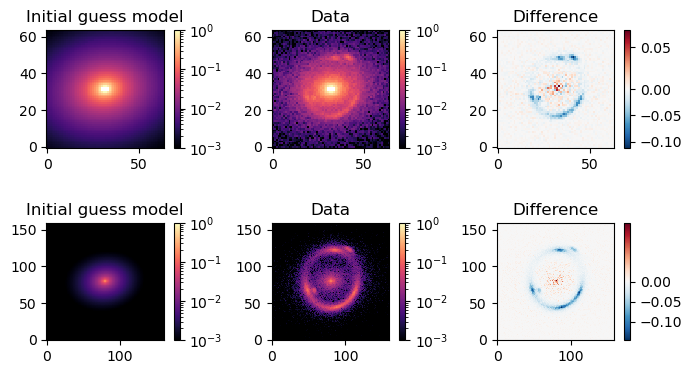

Initial loss for start 2 = 1041219.7730679091
INIT LENS PARAMS: {'light_cx': Array(0.06230302, dtype=float64), 'light_cy': Array(-0.02035359, dtype=float64), 'light_e1': Array(0.17316807, dtype=float64), 'light_e2': Array(0.04112906, dtype=float64), 'lens_theta_E': Array(1.50222621, dtype=float64), 'lens_gamma1': Array(-0.05423462, dtype=float64), 'lens_gamma2': Array(-0.00575768, dtype=float64)}


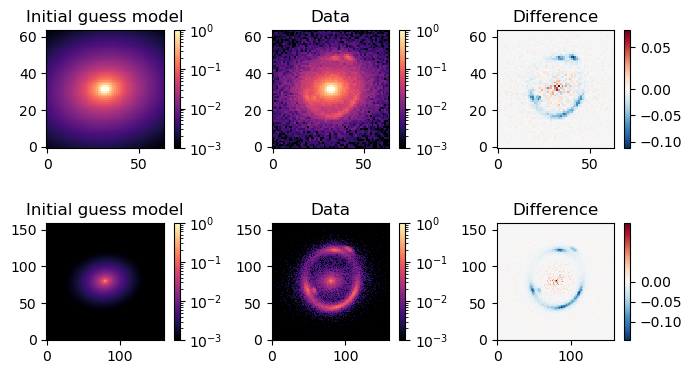

Initial loss for start 3 = 1033908.6273524096
INIT LENS PARAMS: {'light_cx': Array(0.01291036, dtype=float64), 'light_cy': Array(0.02146647, dtype=float64), 'light_e1': Array(0.17098058, dtype=float64), 'light_e2': Array(-0.03558545, dtype=float64), 'lens_theta_E': Array(1.50870024, dtype=float64), 'lens_gamma1': Array(-0.07125518, dtype=float64), 'lens_gamma2': Array(-0.00060414, dtype=float64)}


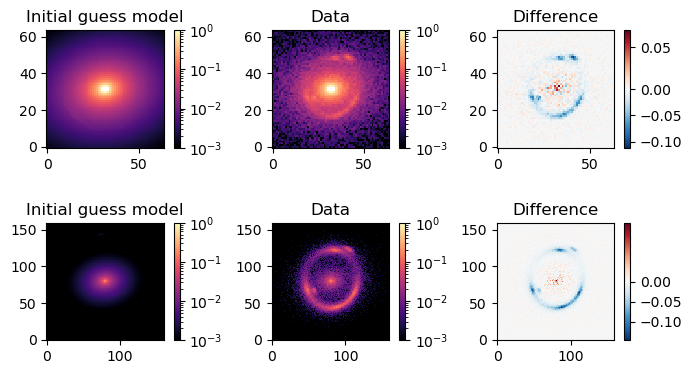

Initial loss for start 4 = 1080675.2320664395
INIT LENS PARAMS: {'light_cx': Array(-0.00666712, dtype=float64), 'light_cy': Array(-0.01133458, dtype=float64), 'light_e1': Array(0.08181822, dtype=float64), 'light_e2': Array(0.00546018, dtype=float64), 'lens_theta_E': Array(1.49704049, dtype=float64), 'lens_gamma1': Array(0.07572411, dtype=float64), 'lens_gamma2': Array(0.02883727, dtype=float64)}


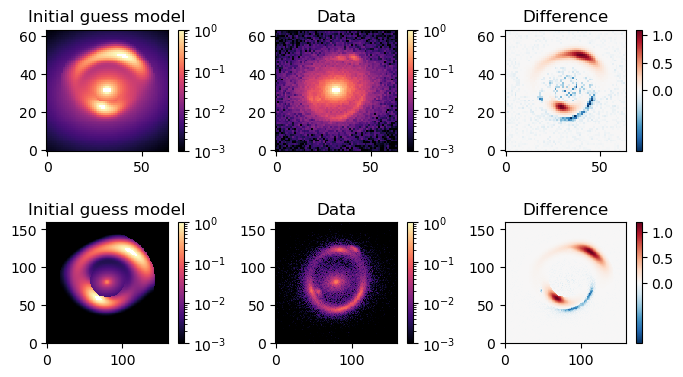

Initial loss for start 5 = 507104.9736660052
INIT LENS PARAMS: {'light_cx': Array(-0.05363404, dtype=float64), 'light_cy': Array(-0.02574997, dtype=float64), 'light_e1': Array(0.17469287, dtype=float64), 'light_e2': Array(0.08889214, dtype=float64), 'lens_theta_E': Array(1.50518906, dtype=float64), 'lens_gamma1': Array(0.05332448, dtype=float64), 'lens_gamma2': Array(0.10301824, dtype=float64)}


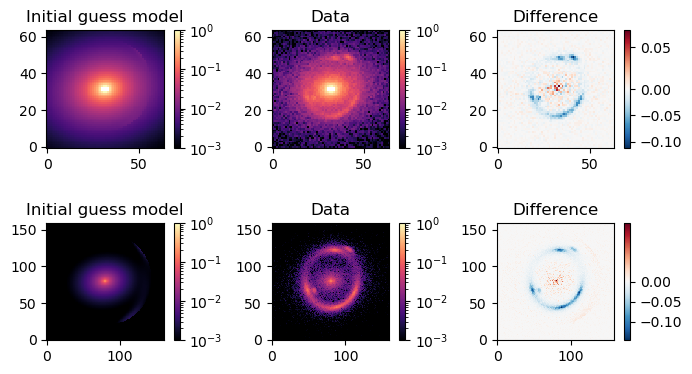

Initial loss for start 6 = 1091649.1391291716
INIT LENS PARAMS: {'light_cx': Array(0.0613688, dtype=float64), 'light_cy': Array(0.0632551, dtype=float64), 'light_e1': Array(0.1641379, dtype=float64), 'light_e2': Array(0.01396722, dtype=float64), 'lens_theta_E': Array(1.50352361, dtype=float64), 'lens_gamma1': Array(-0.03211707, dtype=float64), 'lens_gamma2': Array(0.02998297, dtype=float64)}


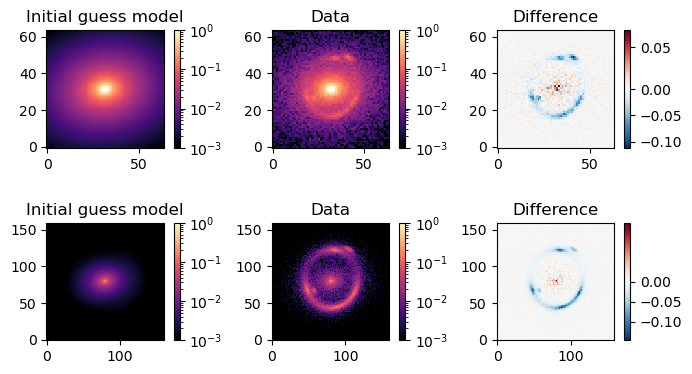

Initial loss for start 7 = 886903.0558342735


In [20]:
# Have a look at the initial guesses
for i, key in enumerate(prng_keys_optim):
    init_params = prob_model.get_sample(prng_key=key)
    print("INIT LENS PARAMS:", {k: v for k, v in init_params.items() if ('lens' in k or 'light' in k)})
    visualize_initial_guess_mb(init_params)
    print(f"Initial loss for start {i} =", loss(prob_model.unconstrain(init_params)))

## Maximum-a-posteriori optimisation

In [21]:
optimizer = hcl.OptaxOptimizer(loss, loss_norm_optim=data_b1.size)

# optimizer settings
max_iterations = 2_000 if not TEST_MODE else 300
init_learning_rate = 1e-3
algorithm = 'adabelief'

def run_optim(key, progress_bar):
    # draw parameters in unconstrained space
    init_unconst = prob_model.unconstrain(
        prob_model.get_sample(prng_key=key)
    )
    # run optimizer
    best_fit_unconst, logL, extra_fields, runtime = optimizer.run(
        init_unconst, 
        algorithm=algorithm,
        max_iterations=max_iterations, 
        init_learning_rate=init_learning_rate,
        progress_bar=progress_bar,
    )
    # return the constrained parameters values
    best_fit = prob_model.constrain(best_fit_unconst)
    return best_fit, logL, extra_fields, runtime

In [22]:
# Using pmap (for some reason this does not seem to work)
# pmap_optim = jax.pmap(run_optim, in_axes=(0, None), static_broadcasted_argnums=(1,)) 
# multi_best_fit, multi_logL, multi_extra_fields, multi_runtime = pmap_optim(prng_keys_optim, False)

# Using vmap
vmap_optim = jax.vmap(run_optim, in_axes=(0, None))
multi_best_fit, multi_logL, multi_extra_fields, multi_runtime = vmap_optim(prng_keys_optim, True)

print("Optimisation runtime for each start:", multi_runtime)

optax.adabelief: 100%|██████████| 2000/2000 [05:26<00:00,  6.12it/s]


Optimisation runtime for each start: [326.98695517 326.98695517 326.98695517 326.98695517 326.98695517
 326.98695517 326.98695517 326.98695517]


Best run: 2


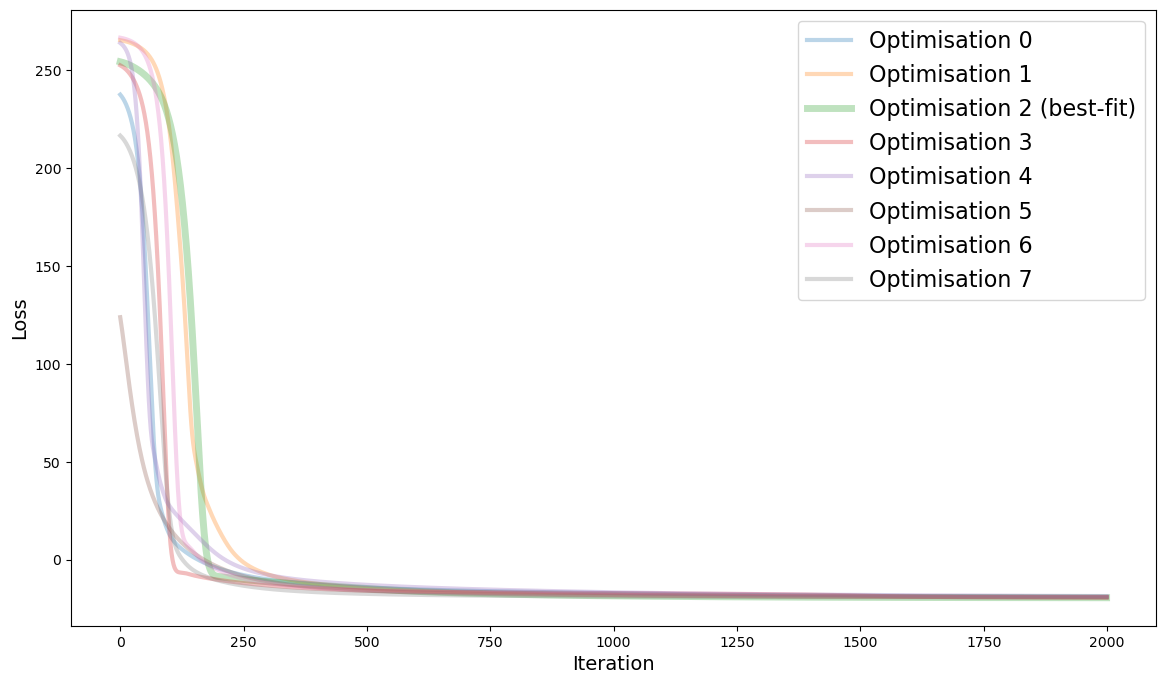

In [23]:
# index of the best model from the multi-start optimisation
idx_best_start = int(np.argmax(multi_logL))
print("Best run:", idx_best_start)

fig, ax = plt.subplots(1, 1, figsize=(14, 8))
for i in range(num_start):
    if i == idx_best_start:
        label = f"Optimisation {i} (best-fit)"
        alpha = 0.3
        linewidth = 5
    else:
        label = f"Optimisation {i}"
        alpha = 0.3
        linewidth = 3
    ax.plot(
        range(len(multi_extra_fields['loss_history'][i])), 
        multi_extra_fields['loss_history'][i], 
        label=label,
        alpha=alpha,
        linewidth=linewidth,
    )
# ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_ylabel("Loss", fontsize=14)
ax.set_xlabel("Iteration", fontsize=14)
ax.legend(fontsize=16)
plt.show()

## Visualize the resulting models

In [24]:
@jax.jit
def get_value_from_index(xs, i):
    """useful helper function for unstacking vmap'ed results"""
    return jax.tree.map(lambda x: x[i], xs)

Final loss for start 2 = -79562.50146382547
========== OPTIM 2 BAND 0 ==========


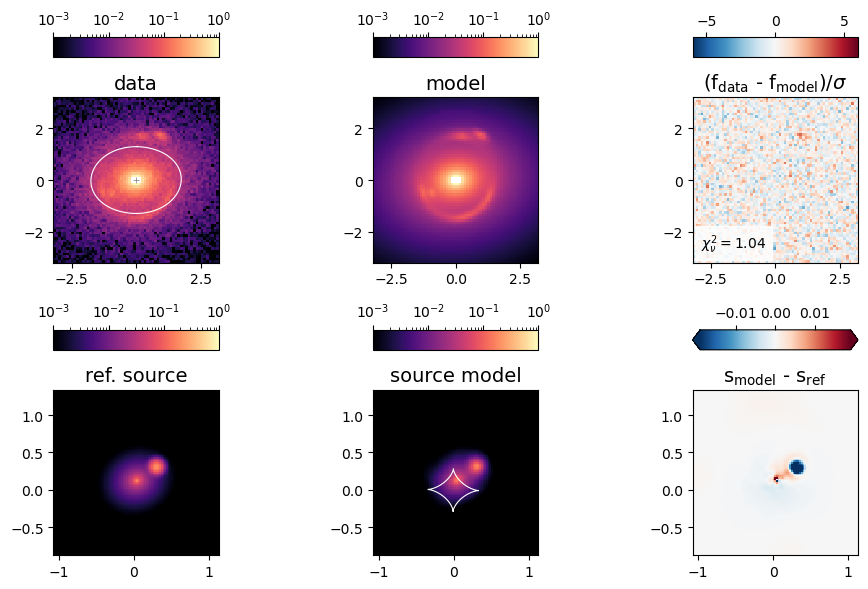

========== OPTIM 2 BAND 1 ==========


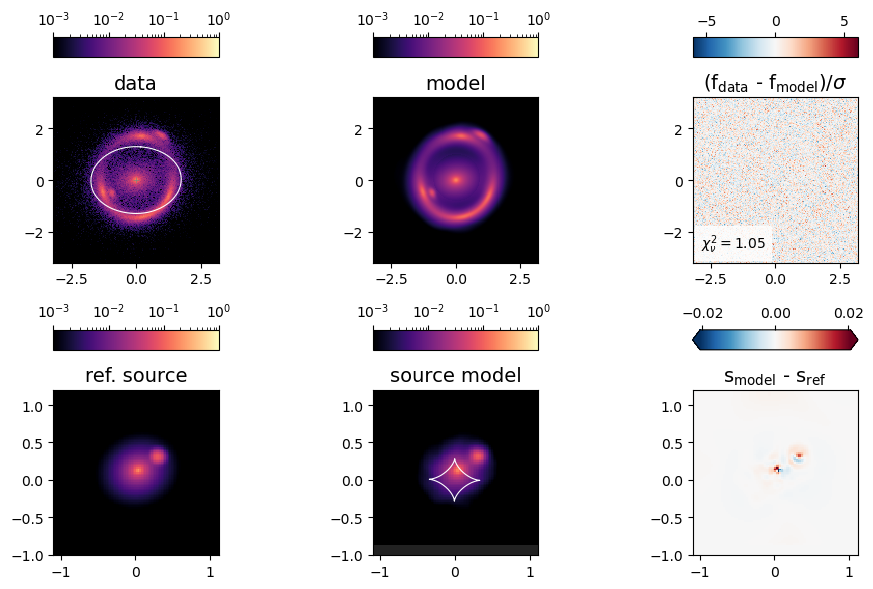

In [25]:
plot_only_best = True

for i in range(num_start):
    if plot_only_best and i != idx_best_start:
        continue
    best_fit_i = get_value_from_index(multi_best_fit, i)
    print(f"Final loss for start {i} =", loss(prob_model.unconstrain(best_fit_i)))

    # retrieve the best-fit parameters as kwargs
    kwargs_best_fit_b1_i, kwargs_best_fit_b2_i = prob_model.params2kwargs(best_fit_i)

    print(f"{10*'='} OPTIM {i} BAND 0 {10*'='}")
    fig = plotter_b1.model_summary(
        lens_image_b1, 
        kwargs_best_fit_b1_i, 
        #kwargs_noise={'background_rms': best_fit_constrained['noise_sigma_bkg']},
        show_source=True, 
        show_lens_lines=True,
        show_plot=False,
        figsize=(10, 6),
    )
    fig.tight_layout()
    plt.show()

    # get the adapted coordinates of the source pixels just to make sure the plots are consistent
    _, source_coords_b1_i = lens_image_b1.source_surface_brightness(
        kwargs_best_fit_b1_i['kwargs_source'], 
        kwargs_lens=kwargs_best_fit_b1_i['kwargs_lens'],
        return_pixels_coords=True,
    )
    print(f"{10*'='} OPTIM {i} BAND 1 {10*'='}")
    fig = plotter_b2.model_summary(
        lens_image_b2, 
        kwargs_best_fit_b2_i, 
        #kwargs_noise={'background_rms': best_fit_constrained['noise_sigma_bkg']},
        show_source=True,
        show_lens_lines=True,
        show_plot=False,
        figsize=(10, 6),
        adapted_source_pixels_coords=source_coords_b1_i,
    )
    fig.tight_layout()
    plt.show()

## Check best-fit point estimate values

In [26]:
# retrieve the best-fit parameters as kwargs
kwargs_best_fit_b1, kwargs_best_fit_b2 = prob_model.params2kwargs(
    get_value_from_index(multi_best_fit, idx_best_start),
)

In [27]:
pprint(kwargs_input_b1['kwargs_lens'])

[{'center_x': 0.0,
  'center_y': 0.0,
  'e1': Array(0.1373231, dtype=float64, weak_type=True),
  'e2': Array(0.03937677, dtype=float64, weak_type=True),
  'theta_E': 1.5},
 {'dec_0': 0.0,
  'gamma1': Array(-0.00927051, dtype=float64, weak_type=True),
  'gamma2': Array(0.0285317, dtype=float64, weak_type=True),
  'ra_0': 0.0}]


In [28]:
pprint(kwargs_best_fit_b1['kwargs_lens'])

[{'center_x': Array(-0.00465754, dtype=float64),
  'center_y': Array(-0.00094114, dtype=float64),
  'e1': Array(0.14318885, dtype=float64),
  'e2': Array(0.0292788, dtype=float64),
  'theta_E': Array(1.50235879, dtype=float64)},
 {'gamma1': Array(-0.0068216, dtype=float64),
  'gamma2': Array(0.02252338, dtype=float64)}]
